In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2
import ast
import scipy  
import sys

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
os.chdir("/content/gdrive/My Drive/Datasets/chest_xray")

In [4]:
from keras.layers import Dense,Flatten,Activation,Dropout,GlobalAveragePooling2D,BatchNormalization
from keras.models import Model
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.preprocessing import image

Using TensorFlow backend.


In [0]:
base_model = MobileNet(weights='imagenet',include_top=False,input_shape=(224,224,3))

x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)


# x = Dense(128,activation="relu")(x)
x = BatchNormalization()(x)
predictions = Dense(2,activation="softmax")(x)

model = Model(inputs=base_model.input,outputs=predictions)
# for layer in model.layers[:80]:
#   layer.trainable = False
for layer in model.layers:
  layer.trainable = True


17227776/17225924 [==============================] - 3s 0us/step


In [0]:
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [0]:
model.compile(optimizer="Adam",loss="binary_crossentropy",metrics=['accuracy'])

In [0]:
train_generator = ImageDataGenerator(horizontal_flip=True,preprocessing_function=preprocess_input, shear_range=0.2,zoom_range=0.2)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = train_generator.flow_from_directory("train",
                                        target_size=(224,224),
                                        color_mode = 'rgb',
                                        batch_size=32,
                                        class_mode='categorical',shuffle=True,)
test_gen = test_generator.flow_from_directory("test",
                                       target_size=(224,224),
                                       color_mode = 'rgb',
                                       batch_size=32,
                                       class_mode='categorical',
                                       shuffle=True)
val_gen = test_generator.flow_from_directory("val",
                                       target_size=(224,224),
                                       color_mode = 'rgb',
                                       batch_size=8,
                                       class_mode='categorical',
                                       shuffle=False)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
step_size_train=train_gen.n//train_gen.batch_size
step_size_test=test_gen.n//train_gen.batch_size
model.fit_generator(generator=train_gen,
                   steps_per_epoch=step_size_train,verbose=2,
                   epochs=5,validation_data=test_gen,validation_steps=step_size_test)

Epoch 1/5
 - 2011s - loss: 0.2734 - acc: 0.9316 - val_loss: 0.4287 - val_acc: 0.8586
Epoch 2/5
 - 140s - loss: 0.0971 - acc: 0.9697 - val_loss: 0.3673 - val_acc: 0.8733
Epoch 3/5
 - 140s - loss: 0.0659 - acc: 0.9783 - val_loss: 0.2900 - val_acc: 0.9105
Epoch 4/5
 - 139s - loss: 0.0868 - acc: 0.9693 - val_loss: 0.3472 - val_acc: 0.9071
Epoch 5/5
 - 140s - loss: 0.0609 - acc: 0.9789 - val_loss: 0.2331 - val_acc: 0.9155


In [0]:
model.save("xray_model_final.h5")

In [5]:
from keras.models import load_model
model = load_model("xray_model_final.h5")







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def pretrained_path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    x = np.expand_dims(x, axis=0)
    # convert RGB -> BGR, subtract mean ImageNet pixel, and return 4D tensor
    return preprocess_input(x)

In [0]:
def get_mobileNet(model):
    # get AMP layer weights
    all_amp_layer_weights = model.layers[-1].get_weights()[0]
    # extract wanted output
    Plot_model = Model(inputs=model.input, 
        outputs=(model.layers[-4].output, model.layers[-1].output)) 
    return Plot_model, all_amp_layer_weights

In [0]:
def mobilenet_CAM(img_path, model, all_amp_layer_weights):
    # get filtered images from convolutional output + model prediction vector
    last_conv_output, pred_vec = model.predict(pretrained_path_to_tensor(img_path))
    # change dimensions of last convolutional outpu tto 7 x 7 x 1024
    last_conv_output = np.squeeze(last_conv_output) 
    # get model's prediction (number between 0 and 999, inclusive)
    pred = np.argmax(pred_vec,axis=1)
    # bilinear upsampling to resize each filtered image to size of original image 
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # dim: 224 x 224 x 1024
    # get AMP layer weights
    amp_layer_weights = all_amp_layer_weights[:, pred] # dim: (1024,) 
    # get class activation map for object class that is predicted to be in the image
    final_output = np.dot(mat_for_mult.reshape((224*224, 1024)), amp_layer_weights).reshape(224,224) # dim: 224 x 224
    # return class activation map
    return final_output

In [0]:
def plot_mobilenet_CAM(img_path, ax, model, all_amp_layer_weights):
    # load image, convert BGR --> RGB, resize image to 224 x 224,
    im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (224, 224))
    # plot image
    ax.imshow(im, alpha=0.5)
    # get class activation map
    CAM= mobilenet_CAM(img_path, model, all_amp_layer_weights)
    # plot class activation map
    ax.imshow(CAM,cmap="jet", alpha=0.5)

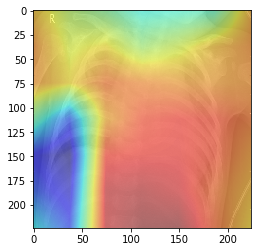

In [0]:
mob_model, all_amp_layer_weights = get_mobileNet(model)
img_path = "test/PNEUMONIA/person112_bacteria_539.jpeg"
fig, ax = plt.subplots()
CAM = plot_mobilenet_CAM(img_path, ax, mob_model, all_amp_layer_weights)
plt.show()